In [1]:
%matplotlib inline


# Example 1: Use of AK- MCS on Branin Hoo function


In [2]:
import matplotlib.pyplot as plt
from matplotlib import cm
import openturns as ot
from openturns.viewer import View
import numpy as np
import otak

ot.RandomGenerator.SetSeed(1)

In [3]:
class DrawFunctions:
    def __init__(self):
        dim = 2
        self.grid_size = 100
        lowerbound = [-5, 0.]
        upperbound = [10., 15.]
        mesher = ot.IntervalMesher([self.grid_size-1] * dim)
        interval = ot.Interval(lowerbound, upperbound)
        mesh = mesher.build(interval)
        self.nodes = mesh.getVertices()
        self.X0, self.X1 = np.array(self.nodes).T.reshape(2, self.grid_size, self.grid_size)

    def draw_2D_controur(self, title, function=None, distribution=None, colorbar=cm.plasma):
        fig = plt.figure(figsize=(7, 6))
        if distribution is not None:
            Zpdf = np.array(distribution.computePDF(self.nodes)).reshape(self.grid_size, self.grid_size)
            nb_isocurves = 9
            contours = plt.contour(self.X0, self.X1, Zpdf, nb_isocurves, colors='black', alpha=0.6)
            plt.clabel(contours, inline=True, fontsize=8)
        if function is not None:
            Z = np.array(function(self.nodes)).reshape(self.grid_size, self.grid_size)
            plt.contourf(self.X0, self.X1, Z, 18, cmap=colorbar)
            plt.colorbar()
        plt.title(title)
        plt.xlabel("$x_0$")
        plt.ylabel("$x_1$")
        return fig

| Definition of Input distribution



In [4]:
dim_inputs = 2
dist_x = ot.ComposedDistribution([ot.Uniform(-5, 10.), ot.Uniform(0., 15.)])
inputVector = ot.RandomVector(dist_x)

| Definition of limit state function



In [5]:
a = 1
# b = 5.1/(4*np.pi**2)
b = 5 / (4 * np.pi ** 2)
c = 5 / np.pi
r = 6
s = 10
t = 1 / (8 * np.pi)
def branin_function(x):
    y = a * (x[1] - b * x[0] ** 2 + c * x[0] - r) ** 2 + \
        s * (1 - t) * np.cos(x[0]) + s
    threshold = 206.
    return [threshold - y]

def branin_function_plot(x):
    x = np.array(x)
    y = a * (x[:, 1] - b * x[:, 0] ** 2 + c * x[:, 0] - r) ** 2 + \
        s * (1 - t) * np.cos(x[:, 0]) + s
    threshold = 206.
    return threshold - y
my_branin = ot.PythonFunction(2, 1, branin_function)

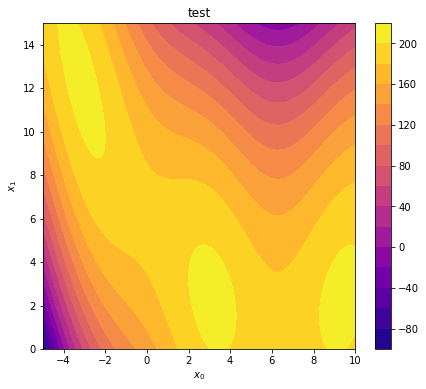

In [6]:
d = DrawFunctions()
d.draw_2D_controur(title="test", function=branin_function_plot);

| Definition of event



In [7]:
Y = ot.CompositeRandomVector(my_branin, inputVector)
my_event = ot.ThresholdEvent(Y, ot.Less(), 0.0)

In [8]:
reference_pf = my_event.getSample(1000000).computeMean()[0]
print("Monte Carlo reference failure probability: {}".format(reference_pf))

Monte Carlo reference failure probability: 0.009585


| Run of AK MCS



In [9]:
dim_4b = 2
basis = ot.ConstantBasisFactory(dim_4b).build()
covarianceModel = ot.MaternModel(dim_4b)
n_MC_4b = 100000
n_DoE_4b = 20
sim_budget_4b = 200
verbose = False
criterion = 2

my_AK_four_branch = otak.AK_MCSAlgorithm(my_event,
                                    n_MC_4b,
                                    n_DoE_4b,
                                    sim_budget_4b,
                                    basis,
                                    covarianceModel,
                                    criterion,
                                    verbose)

my_AK_four_branch.compute_proba()

print('Probability of failure',my_AK_four_branch.getFailureProbability())
print('Simulation budget',my_AK_four_branch.getSimBudget())
print('Coefficient of variation',my_AK_four_branch.getCoefficientOfVariation())

WRN - Warning! For coherency we set scale upper bounds = [28.692,29.298]
WRN - Warning! For coherency we set scale upper bounds = [28.692,29.6074]
WRN - (previous message repeated 6 times)
WRN - Warning! For coherency we set scale upper bounds = [28.692,29.6114]
WRN - (previous message repeated 9 times)
WRN - Warning! For coherency we set scale upper bounds = [29.9018,29.8274]
WRN - (previous message repeated 2 times)
WRN - Warning! For coherency we set scale upper bounds = [29.9376,29.8274]
WRN - (previous message repeated 6 times)
WRN - Warning! For coherency we set scale upper bounds = [29.9376,29.9327]


Probability of failure 0.00962
Simulation budget 51
Coefficient of variation 0.032085838613024276


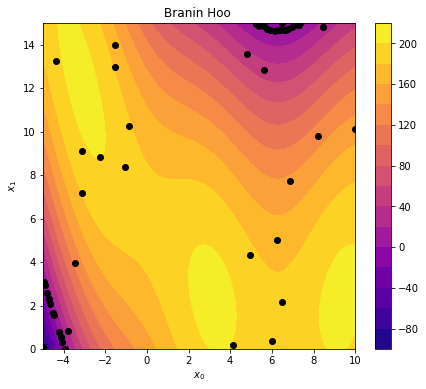

In [10]:
akda_design = my_AK_four_branch.DoE[0]
d.draw_2D_controur(title="Branin Hoo ", function=branin_function_plot)
plt.scatter(akda_design[:, 0], akda_design[:, 1], color='k')

In [11]:
branin_function([10., 10.])

[151.48933708564198]